In [1]:
import os 
os.chdir("..")

In [2]:
import numpy as np
import torch
import matplotlib
from tqdm import tqdm
from matplotlib import rc

# Set the font dictionaries (for correct font properties)
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['axes.labelsize'] = 11
matplotlib.rcParams['font.size'] = 11
rc('text', usetex=True)

import matplotlib.pyplot as plt

In [3]:
from main import train_single_model_from_config
from utils.setup import load_data_module
import yaml

{'a/b/c': 1, 'a/b/d': 2, 'a/e': 3, 'f': 4}


2024-03-30 08:55:55.474704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 08:55:55.474737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 08:55:55.475943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 08:55:55.483660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 08:55:56.467321: W tensorflow/compiler/tf2

In [4]:
config_file = "configs/notebook_configs/config_mdn_full_recalibration.yml"
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

In [5]:
dm = load_data_module(**config["data_hyperparameters"])

In [6]:
model = train_single_model_from_config(config_file)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
val_nll_loss: 2.5837838229011085, train-loss: 0.2069549858570099:   7%|▋         | 33/500 [00:09<02:02,  3.81it/s]  

Epoch 00033: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.5873995294757917, train-loss: 0.17464014887809753:   7%|▋         | 36/500 [00:10<02:21,  3.28it/s]

Early stopping


In [7]:
k = 256
y_grid_size = 2**13
confidence_grid = torch.linspace(1/k, 1 - 1/k, k)
y_space = model.y_space
y_space = torch.linspace(y_space.min().item() - model.std_y.item(), y_space.max().item() + model.std_y.item(), y_grid_size)
scaling_factor = ((y_space.max() - y_space.min())/len(y_space))**-1

In [8]:
scaling_factor

tensor(114.2024)

In [9]:
required_ps = []
with torch.no_grad():
    for x, y in tqdm(dm.get_train_dataloader(64)):

        x = x.to("cuda")
        y = y.to("cuda")

        required_p = model.get_required_conformal_p_values(x, y, torch.tensor(y_space, device="cuda"))
        del x, y
        required_ps.append(required_p)
required_ps = torch.cat(required_ps, 0)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_56084/3093232464.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  required_p = model.get_required_conformal_p_values(x, y, torch.tensor(y_space, device="cuda"))
100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


In [10]:
required_ps = required_ps.cpu()

In [11]:
calibrated_confidence_grid = torch.quantile(required_ps.float(), confidence_grid)

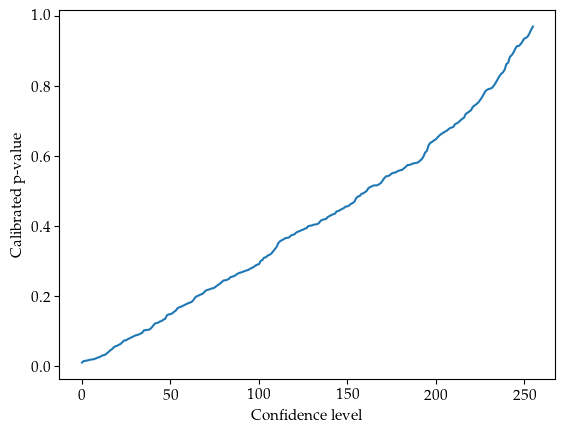

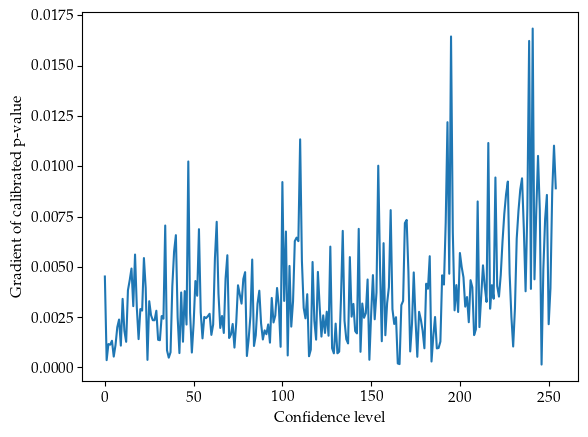

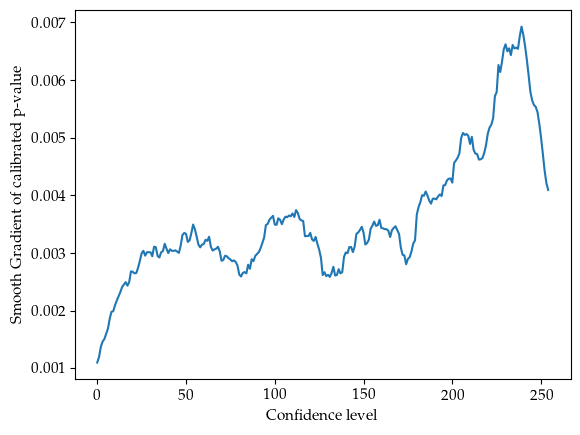

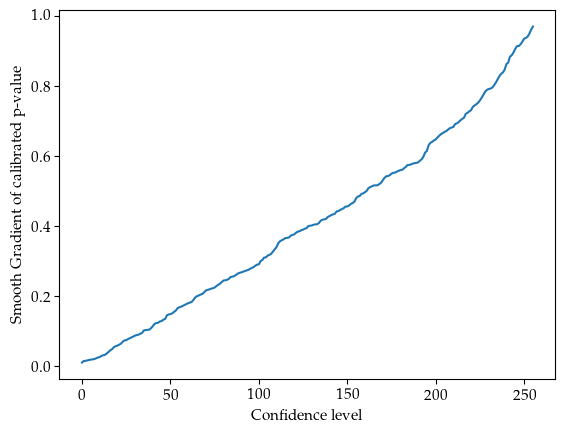

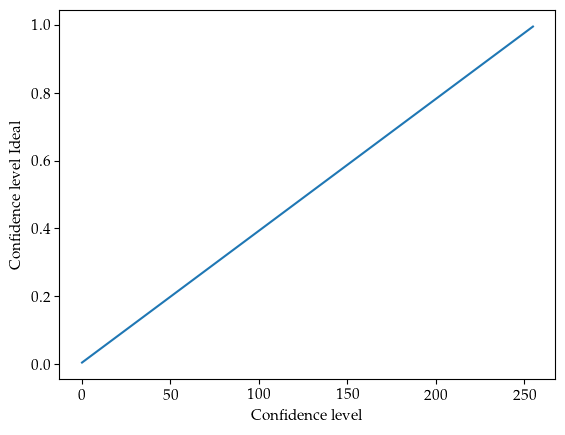

In [12]:
%matplotlib inline
plt.plot(calibrated_confidence_grid.detach().numpy())
plt.xlabel("Confidence level")
plt.ylabel("Calibrated p-value")
plt.show()


grad = calibrated_confidence_grid[1:] - calibrated_confidence_grid[:-1]
plt.plot(grad.detach().numpy())
plt.xlabel("Confidence level")
plt.ylabel("Gradient of calibrated p-value")
plt.show()

window_size = k//8
filter_ = np.ones(window_size) / window_size

grad_grid_smooth = np.convolve(grad, filter_, mode='same')
plt.plot(grad_grid_smooth)
plt.xlabel("Confidence level")
plt.ylabel("Smooth Gradient of calibrated p-value")
plt.show()

smooth_calibrated_confidence_grid = np.cumsum(grad_grid_smooth)
smooth_calibrated_confidence_grid /= np.max(smooth_calibrated_confidence_grid)
smooth_calibrated_confidence_grid -= 1/k
plt.plot(calibrated_confidence_grid)
plt.xlabel("Confidence level")
plt.ylabel("Smooth Gradient of calibrated p-value")
plt.show()
#calibrated_confidence_grid = torch.tensor(smooth_calibrated_confidence_grid)

plt.plot(confidence_grid.detach().numpy())
plt.xlabel("Confidence level")
plt.ylabel("Confidence level Ideal")
plt.show()

In [13]:
model = model.cuda()

In [14]:
scaling_factor = scaling_factor.cpu()

/tmp/ipykernel_56084/1260219333.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdr_before = model.get_hdr(x, confidence_grid.cuda(), torch.tensor(y_space).cuda())
/tmp/ipykernel_56084/1260219333.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), torch.tensor(y_space).cuda())
/tmp/ipykernel_56084/1260219333.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  density_grid = model.get_density_grid(x, torch.tensor(y_space).cuda())


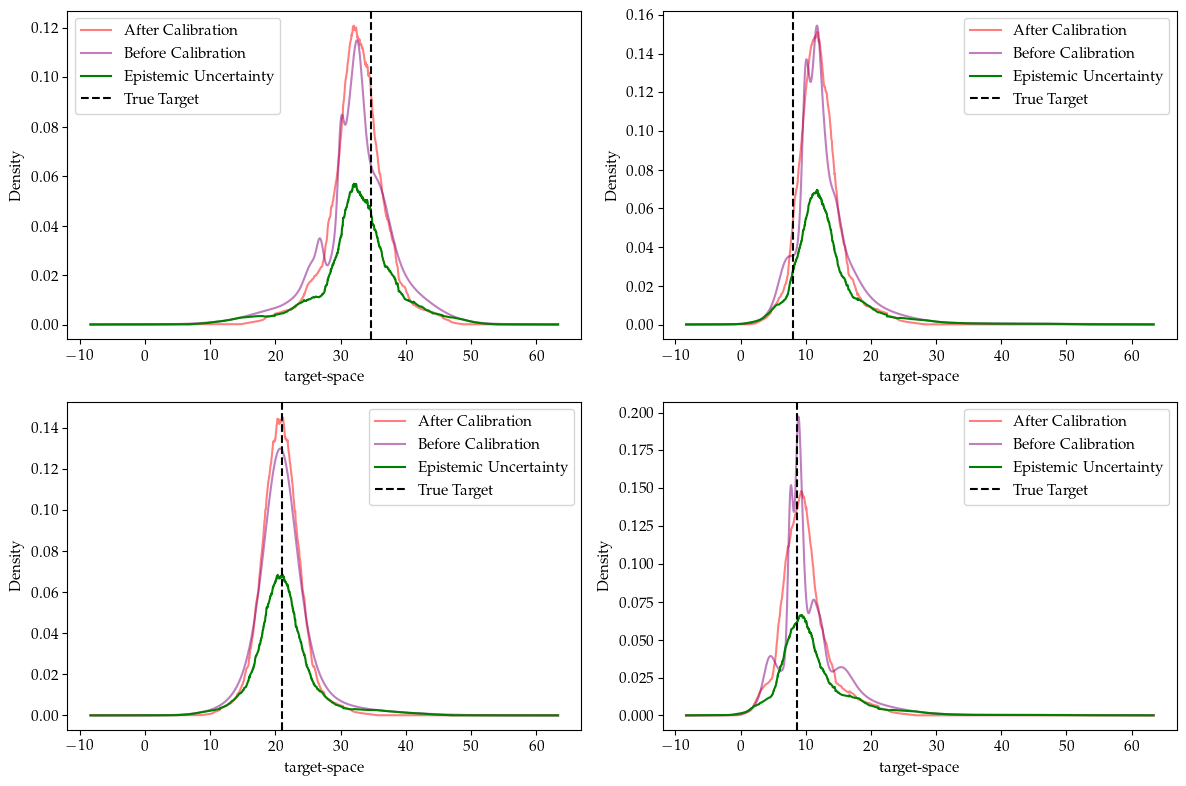

/tmp/ipykernel_56084/1260219333.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdr_before = model.get_hdr(x, confidence_grid.cuda(), torch.tensor(y_space).cuda())
/tmp/ipykernel_56084/1260219333.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), torch.tensor(y_space).cuda())
/tmp/ipykernel_56084/1260219333.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  density_grid = model.get_density_grid(x, torch.tensor(y_space).cuda())


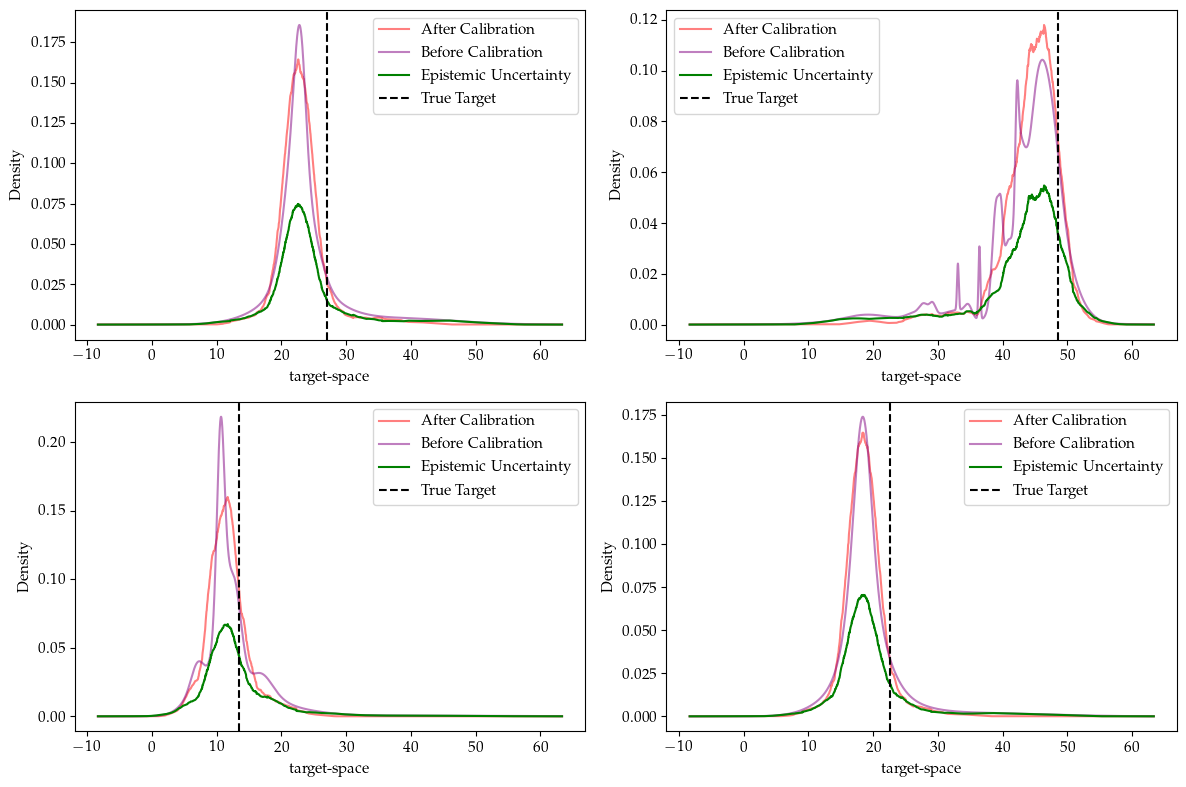

In [15]:
ll_before = []
ll_after = []
ll_before_original = []
ll_maxim = []
with torch.no_grad():
    for x, y in dm.get_test_dataloader(64):


        x = x.to("cuda")

        hdr_before = model.get_hdr(x, confidence_grid.cuda(), torch.tensor(y_space).cuda())
        hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), torch.tensor(y_space).cuda())
        density_grid = model.get_density_grid(x, torch.tensor(y_space).cuda())

        hdr_before = hdr_before.cpu()
        hdr_after = hdr_after.cpu()
        density_grid = density_grid.cpu()

        fig, axs = plt.subplots(2, 2, figsize=(12, 8))

        for sample_no in range(len(hdr_before)):
            before, after = hdr_before[sample_no].clone().detach().numpy(), hdr_after[sample_no].clone().detach().numpy()
            density_grid_before = density_grid[sample_no].clone().detach().numpy()

            before = np.concatenate([before, np.ones_like(before[:1])], 0)
            after = np.concatenate([after, np.ones_like(after[:1])], 0)

            before[1:] =  np.bitwise_xor(before[1:], before[:-1])
            after[1:] =  np.bitwise_xor(after[1:], after[:-1])


            before_grid = np.zeros_like(y_space)
            after_grid = np.zeros_like(y_space)

            #plt.figure(figsize=(8, 6))

            for i in range(before.shape[0]):
                i_sum = np.sum(before[i])
                if i_sum == 0:
                    continue
                level = 1 / i_sum

                active_where = y_space[before[i]]
                before_grid[before[i]] = level
                #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue", alpha=1- (i / before.shape[0]))

            #plt.legend()
            #plt.show()

            #plt.figure(figsize=(8, 6))

            for i in range(after.shape[0]):
                i_sum = np.sum(after[i])
                if i_sum == 0:
                    continue
                level = 1 / i_sum

                active_where = y_space[after[i]]
                after_grid[after[i]] = level
                #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue",alpha=1- (i / before.shape[0]))
            #plt.legend()
            #plt.show()

            

            window_size = y_grid_size//16
            filter_ = np.ones(window_size) / window_size

            c_before = np.convolve(before_grid, filter_, mode='same')
            c_after = np.convolve(after_grid, filter_, mode='same')
            c_epistemic = np.convolve(np.abs(before_grid - after_grid), filter_, mode='same')

            scaled_before_original = scaling_factor * density_grid_before / np.sum(density_grid_before)
            scaled_before = scaling_factor * c_before / np.sum(c_before)
            scaled_after = scaling_factor * c_after / np.sum(c_after)

            maxim = np.maximum(scaled_before_original, scaled_after)
            scaled_maxim = scaling_factor * maxim / np.sum(maxim.numpy())

            ll_after.append(scaled_after[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
            ll_before.append(scaled_before[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
            ll_before_original.append(scaled_before_original[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
            ll_maxim.append(scaled_maxim[np.argmin(np.abs(y_space - y[sample_no].numpy()))])

            
            if ll_after[-1] == 0 or ll_before[-1] == 0 or ll_before_original[-1] == 0 or sample_no < 4:




                # Your existing code for plotting
                
                # Calculate the row and column index in the grid
                row = sample_no // 2
                col = sample_no % 2
                
                # Plot the figure in the corresponding subplot
                axs[row, col].plot(y_space, scaled_after, label='After Calibration', color='red', alpha=0.5)
                axs[row, col].plot(y_space, scaled_before_original, label='Before Calibration', color='purple', alpha=0.5)
                axs[row, col].plot(y_space, scaling_factor * c_epistemic/np.sum(c_before), label='Epistemic Uncertainty', color='green')
                axs[row, col].axvline(y[sample_no], color='black', linestyle='--', label='True Target')
                axs[row, col].set_xlabel('target-space')
                axs[row, col].set_ylabel('Density')
                axs[row, col].legend()



                # plt.figure(figsize=(20, 10))
                # #plt.plot(y_space, scaled_before, label='Before Calibration', color='blue', alpha=0.5)
                # #plt.plot(y_space, c_before / np.sum(c_before), label='Before Calibration', color='blue', alpha=0.5)
                # plt.plot(y_space, scaled_after, label='After Calibration', color='red', alpha=0.5)
                # plt.plot(y_space, scaled_before_original, label='Before Calibration', color='purple', alpha=0.5)
                # plt.plot(y_space, scaling_factor * c_epistemic/np.sum(c_before), label='Epistemic Uncertainty', color='green')
                # plt.axvline(y[sample_no], color='black', linestyle='--', label='True Target')
                # plt.xlabel('target-space')
                # plt.ylabel('Density')
                # plt.legend()
                # plt.show()
        plt.tight_layout()
        #plt.suptitle("Calibration of HDRs on Test Data")
        plt.show()



In [16]:
np.log(ll_before_original).mean()

-2.5740604

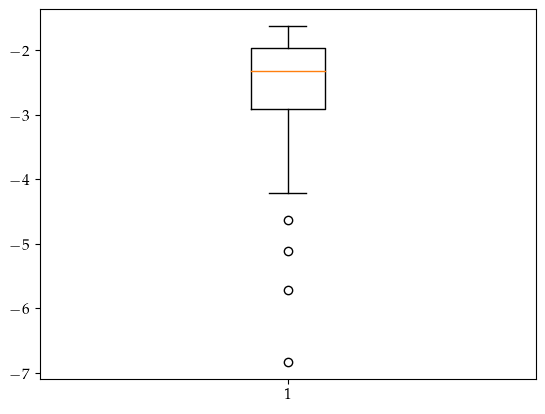

In [17]:
plt.boxplot(np.log(ll_before_original))
plt.show()

In [18]:
np.log(ll_before).mean()

-2.5678746838189355

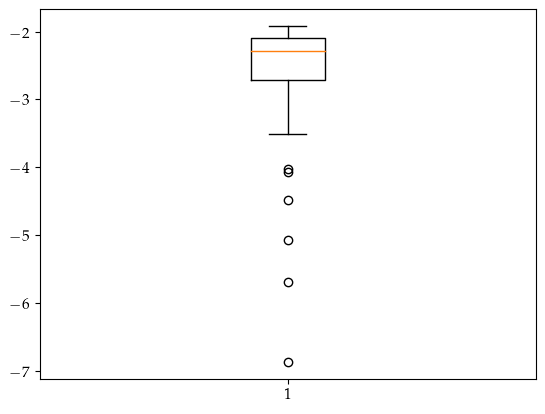

In [19]:
plt.boxplot(np.log(ll_before))
plt.show()

In [20]:
np.log(ll_after).mean()

-2.5085051166486934

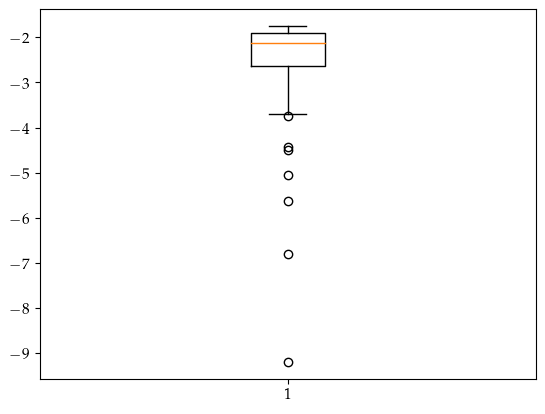

In [21]:
plt.boxplot(np.log(ll_after))
plt.show()

In [22]:
np.log(ll_maxim).mean()

-2.5380689297068466

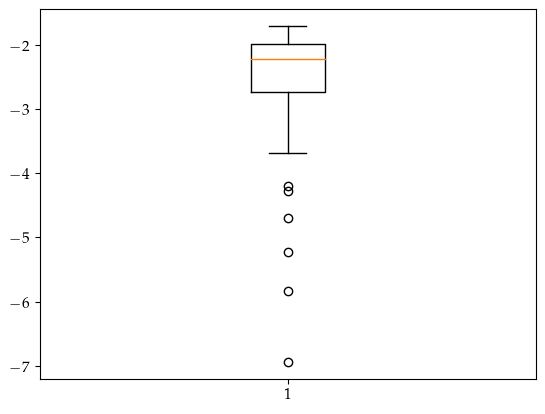

In [23]:
plt.boxplot(np.log(ll_maxim))
plt.show()

# SOTA :D